In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import re

Get filenames

In [58]:
base_path = "G:\\Data\\Projects\\NbSe2\\Tc correlation measurements\\SetD2_ref\\"
# timetraces = glob.glob(base_path + "Timetrace\\*.txt")
podmrs = glob.glob(base_path + "PODMR\\*_range0.dat")
hechos = glob.glob(base_path + "Hecho\\*_pulsed_measurement.dat")

Analyse PODMR

In [44]:
podmr_meas0 = np.zeros(len(podmrs))
podmr_meas1 = np.zeros(len(podmrs))
podmr_meas2 = np.zeros(len(podmrs))
temps = np.zeros(len(podmrs))

for i in range(len(podmrs)):
    path = podmrs[i]
    data_raw = np.loadtxt(path).T
    
    tempstr = re.search(r'temp_.*K', path)
    temps[i] = float(tempstr.group()[5:-1])
    
    var_list,data = (data_raw[0],data_raw[1])

    mode = ''

    #Determine fit

    if mode == 'double':
        fit = afm_scanner_logic._fitlogic.make_lorentziandouble_fit(var_list,data,estimator=afm_scanner_logic._fitlogic.estimate_lorentziandouble_dip)
        lm,_ = fitlogic.make_lorentziandouble_model()

    elif mode == 'N15':
        fit = afm_scanner_logic._fitlogic.make_lorentziandouble_fit(var_list,data,estimator=afm_scanner_logic._fitlogic.estimate_lorentziandouble_N15)
        lm,_ = fitlogic.make_lorentziandouble_model()

    elif mode == 'N14':
        fit = afm_scanner_logic._fitlogic.make_lorentziandouble_fit(var_list,data,estimator=afm_scanner_logic._fitlogic.estimate_lorentziandouble_N14)
        lm,_ = fitlogic.make_lorentziandouble_model()

    else:    
        fit = afm_scanner_logic._fitlogic.make_lorentzian_fit(var_list,data,estimator=afm_scanner_logic._fitlogic.estimate_lorentzian_dip)
        lm,_ = fitlogic.make_lorentzian_model()

    bias_res_freq = fit.params['center'].value

    #Plot Data an
#     plt.plot(var_list,data,'bo')

#     x = np.linspace(var_list[0],var_list[-1],10000, endpoint=True)
#     plt.plot(x, lm.eval(fit.params, x=x),'r-')

#     plt.show()
    fwhm_bias = fit.params['fwhm'].value*1e-6 #FWHM in MHz
    fwhm_bias_err = fit.params['fwhm'].stderr*1e-6 #FWHM in MHz
    bias_res_freq = fit.params['center'].value*1e-6 #FWHM in MHz
    podmr_meas0[i] = fwhm_bias
    podmr_meas1[i] = bias_res_freq
    podmr_meas2[i] = fit.params['contrast'].value*-1
#     print(bias_res_freq,'MHz')
#     print(fwhm_bias,'MHz')

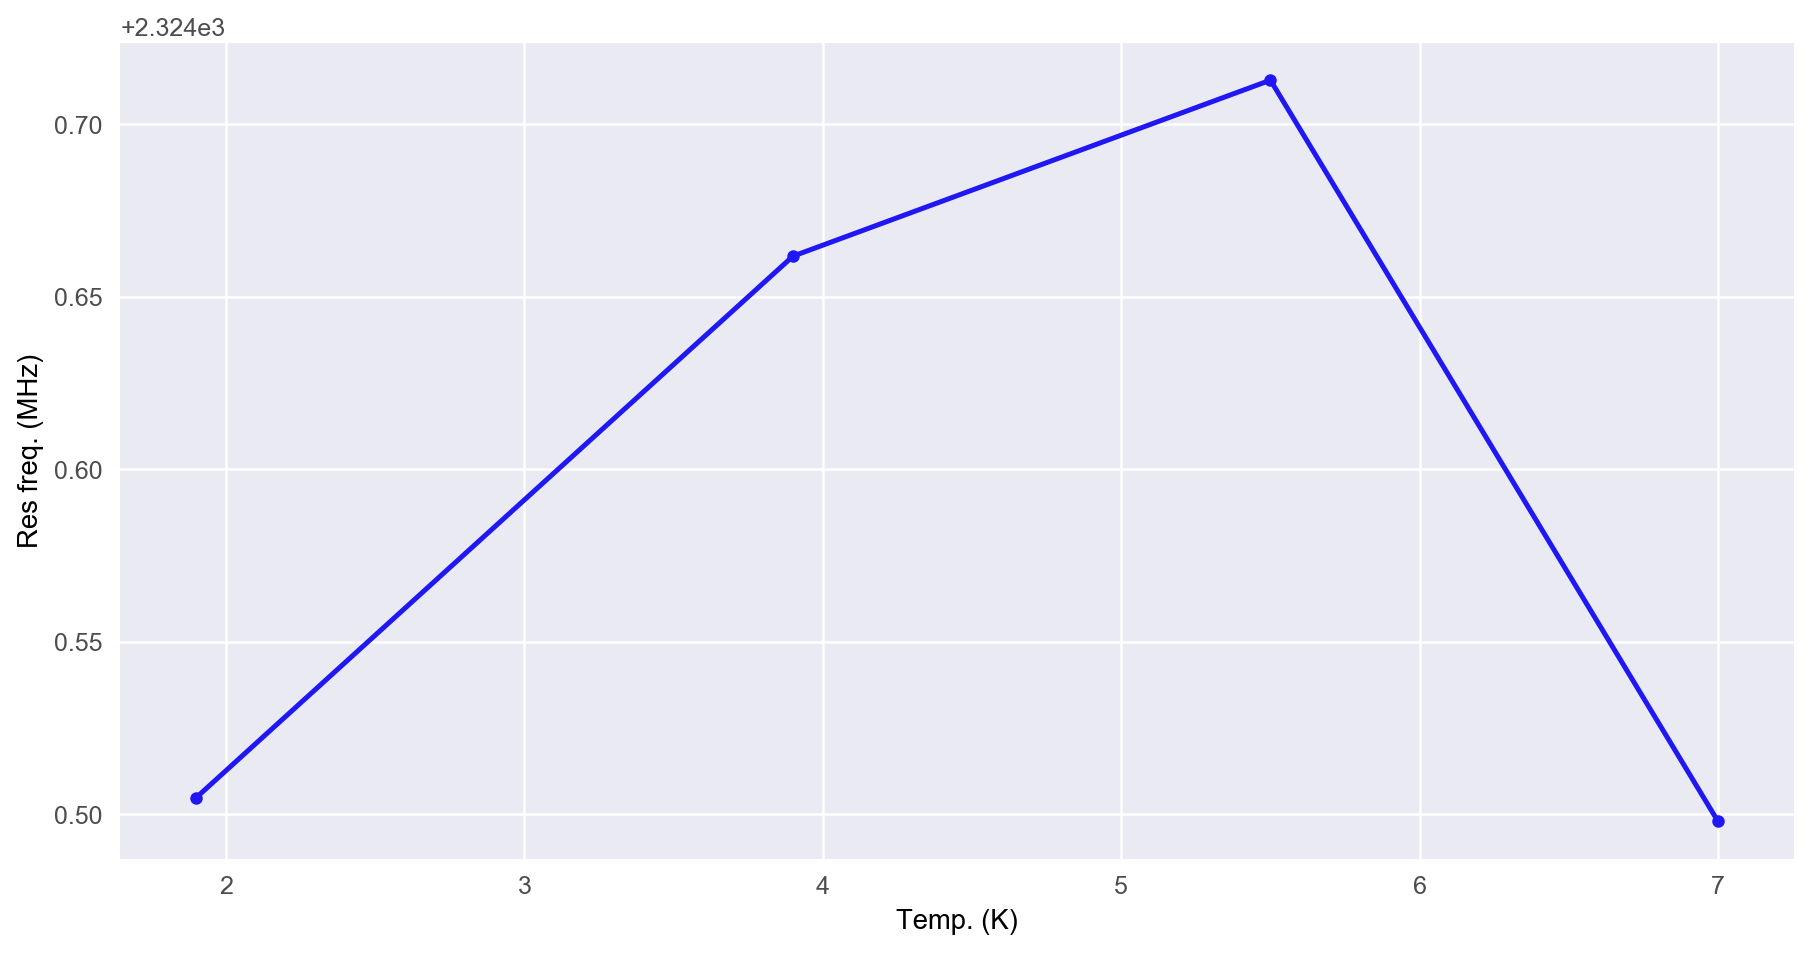

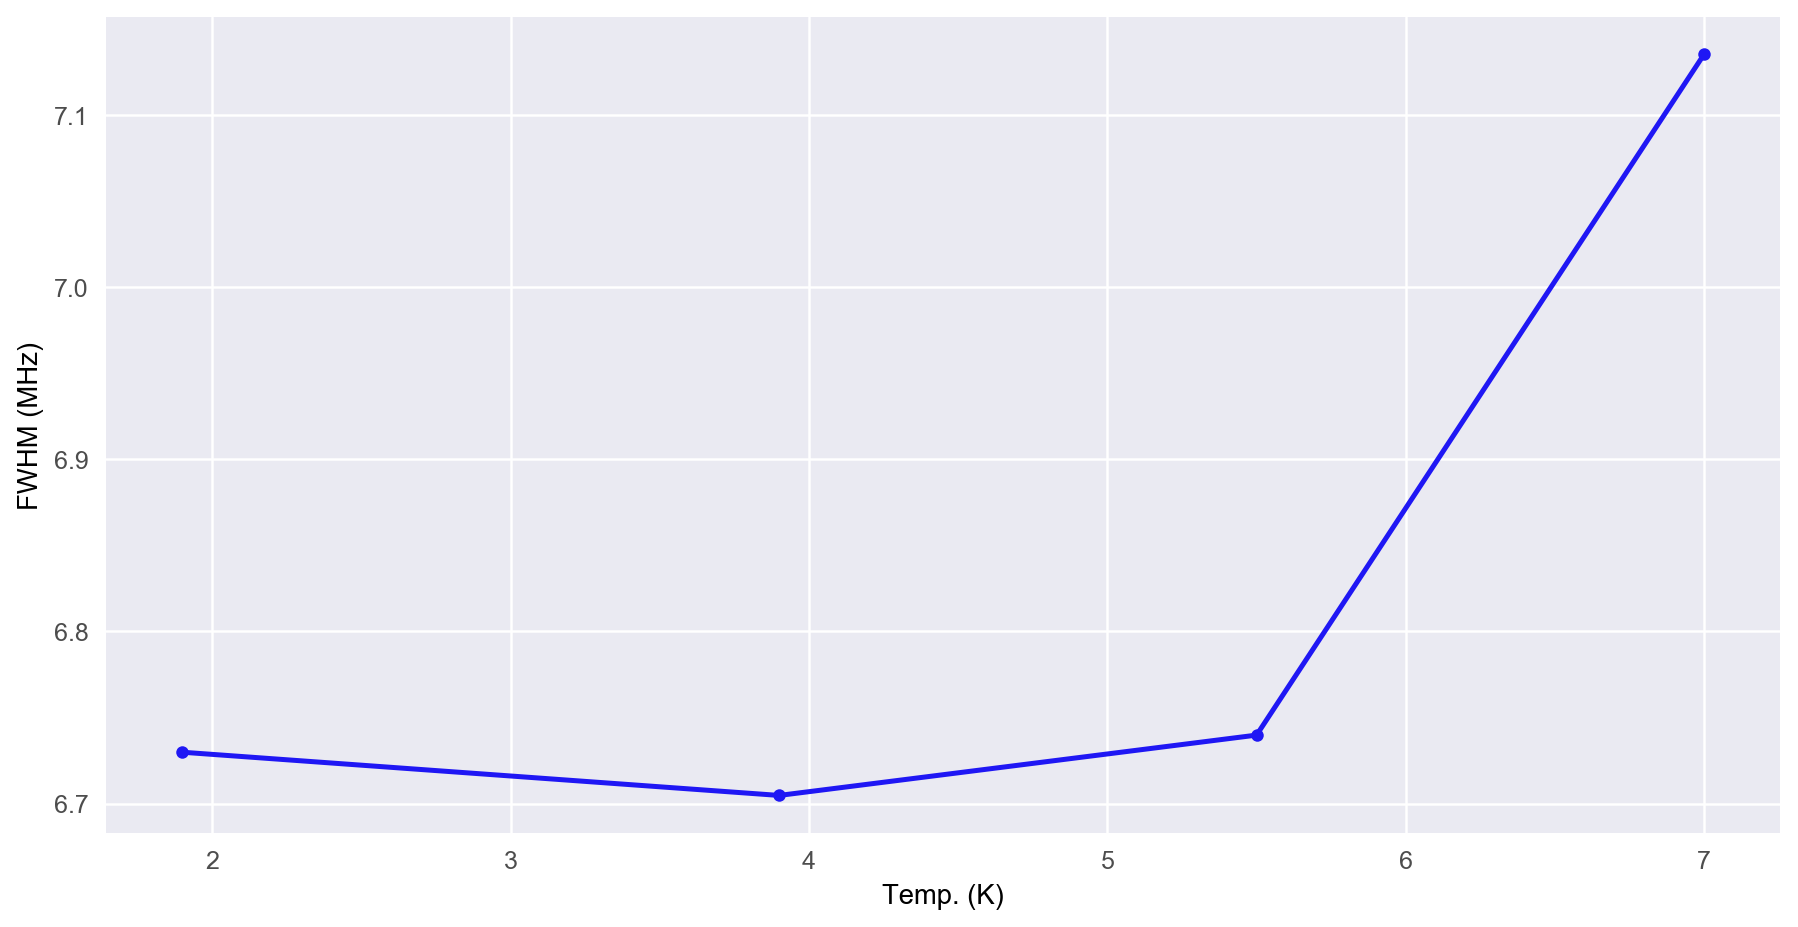

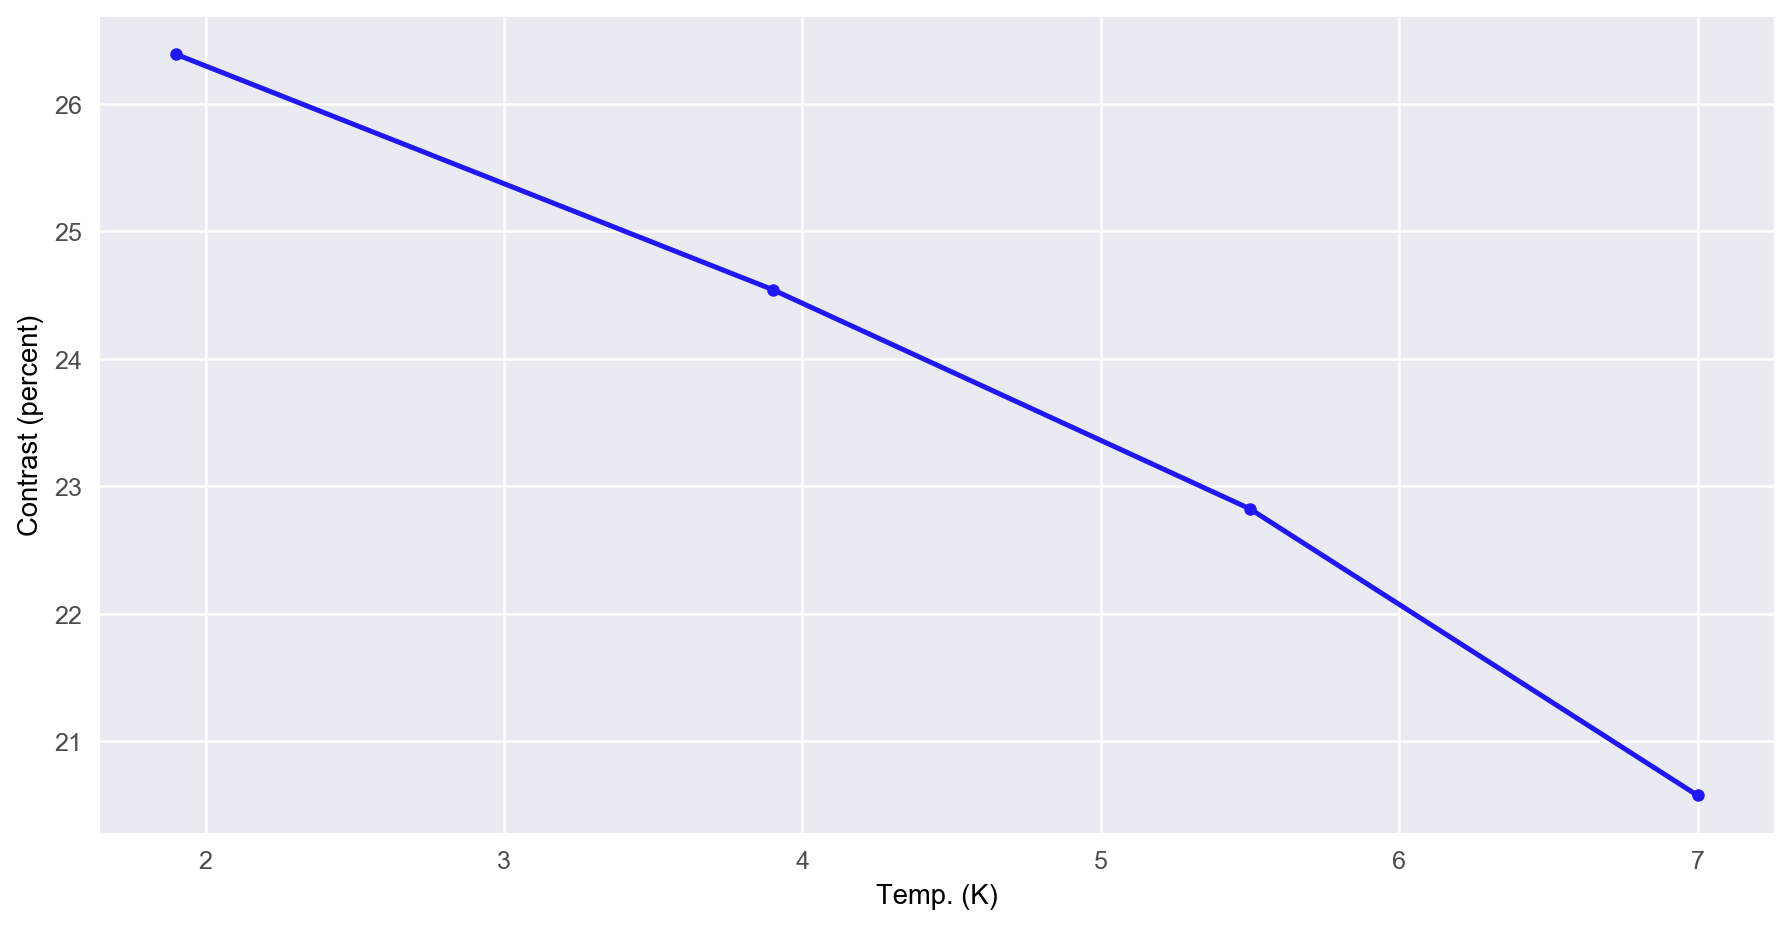

In [45]:
plt.plot(temps, podmr_meas1)
plt.ylabel("Res freq. (MHz)")
plt.xlabel("Temp. (K)")
plt.show()

plt.plot(temps, podmr_meas0)
plt.ylabel("FWHM (MHz)")
plt.xlabel("Temp. (K)")
plt.show()

plt.plot(temps, podmr_meas2)
plt.ylabel("Contrast (percent)")
plt.xlabel("Temp. (K)")
plt.show()

Analyse HEcho

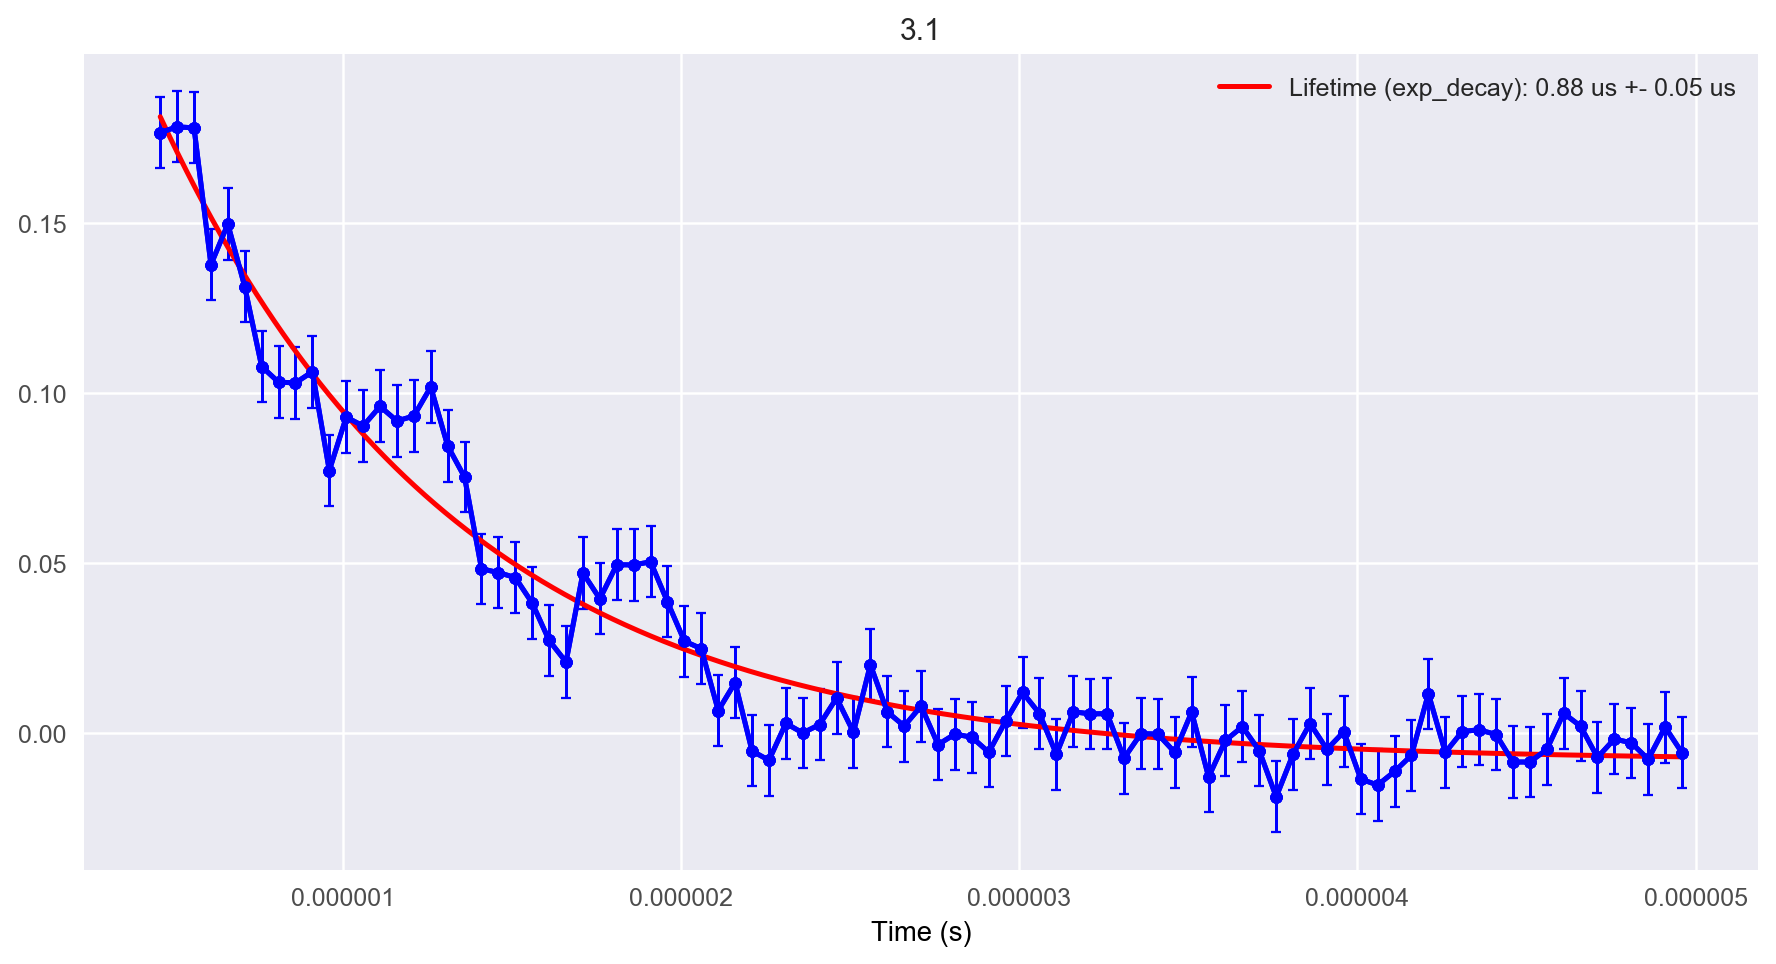

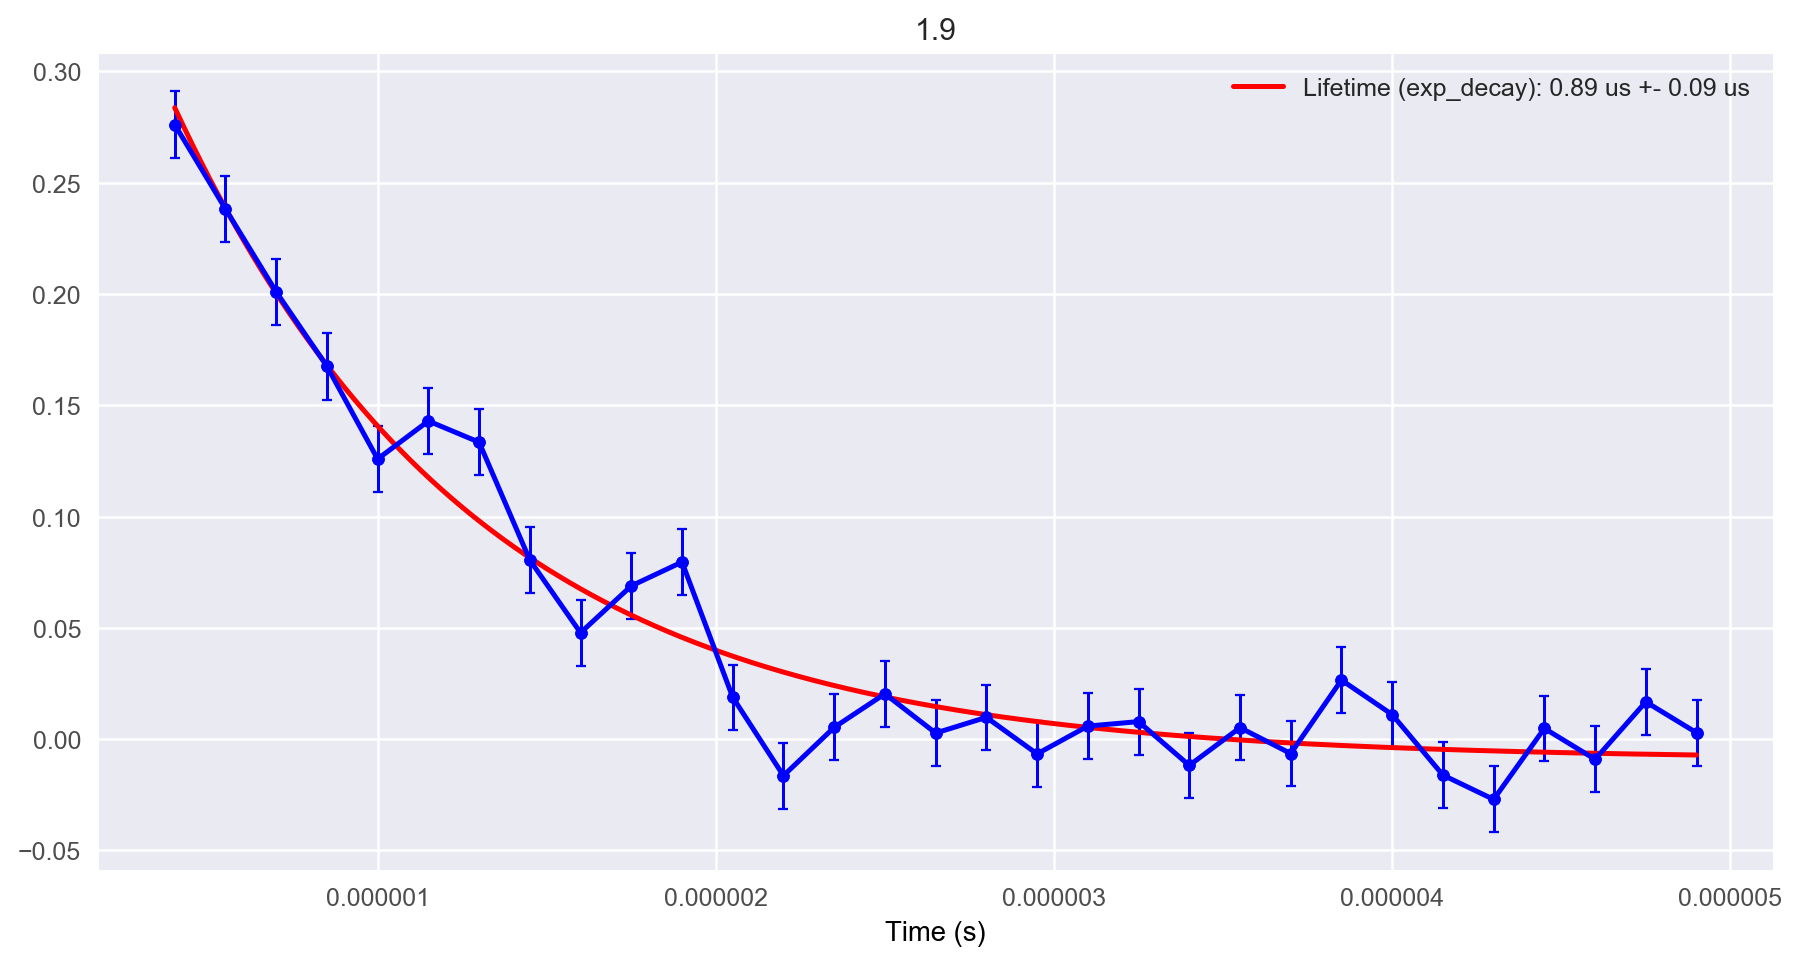

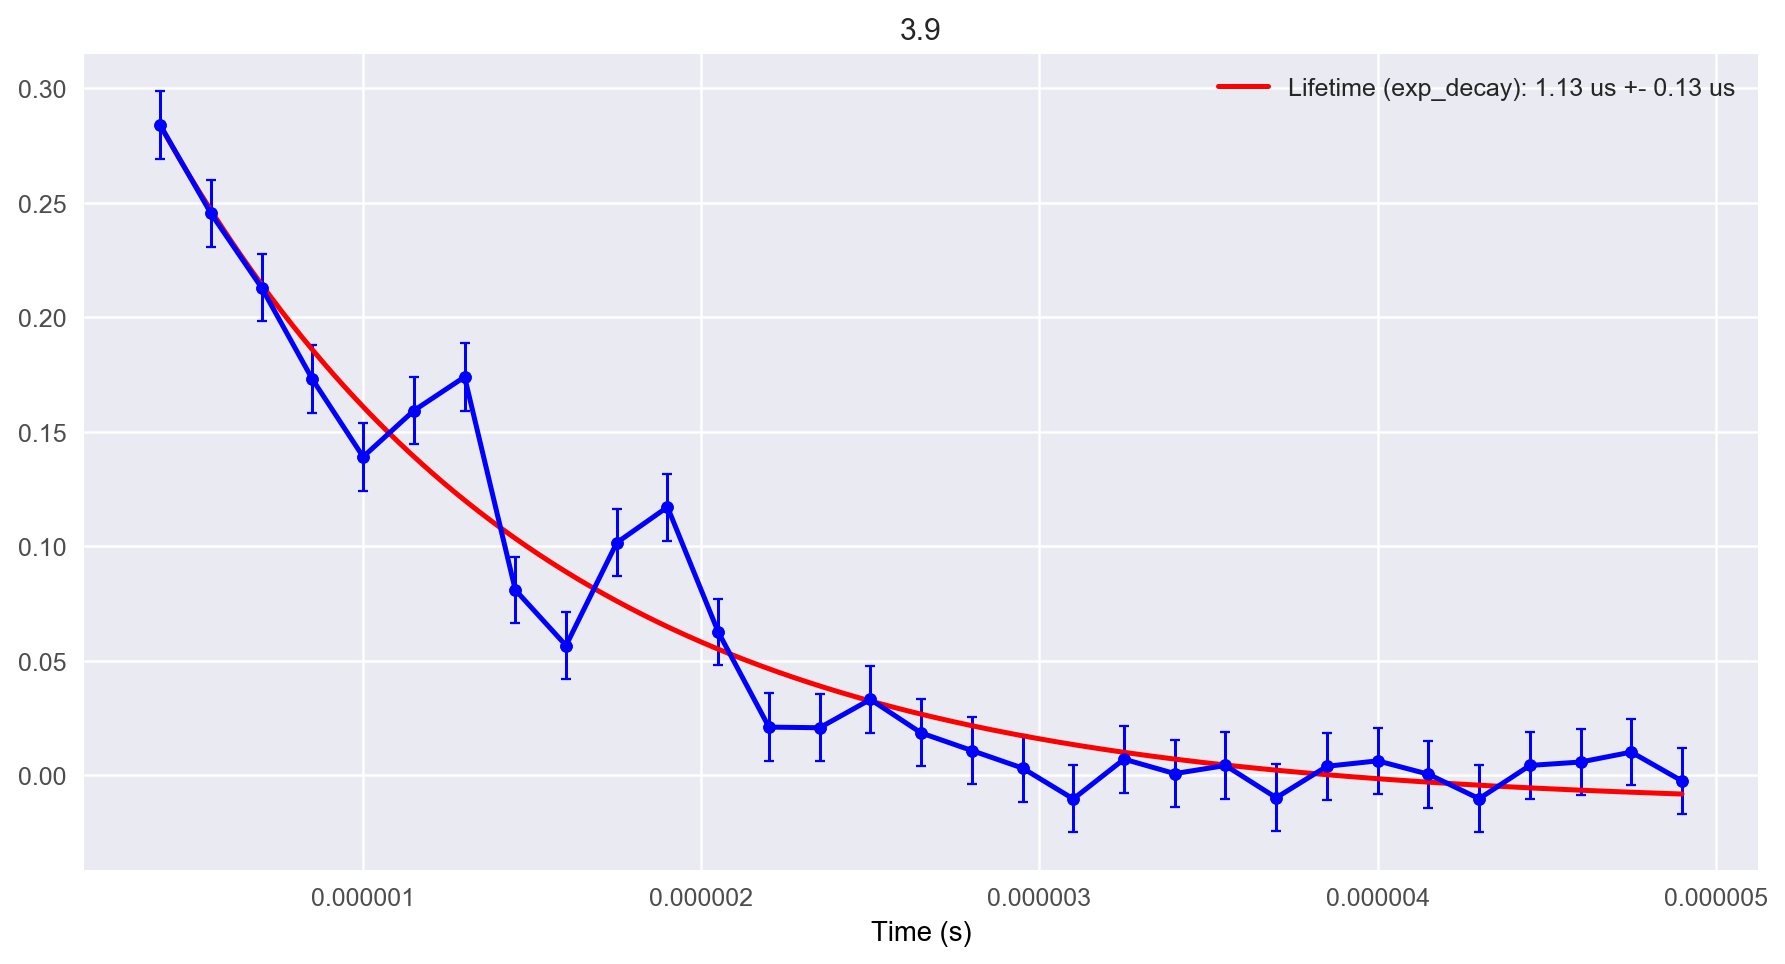

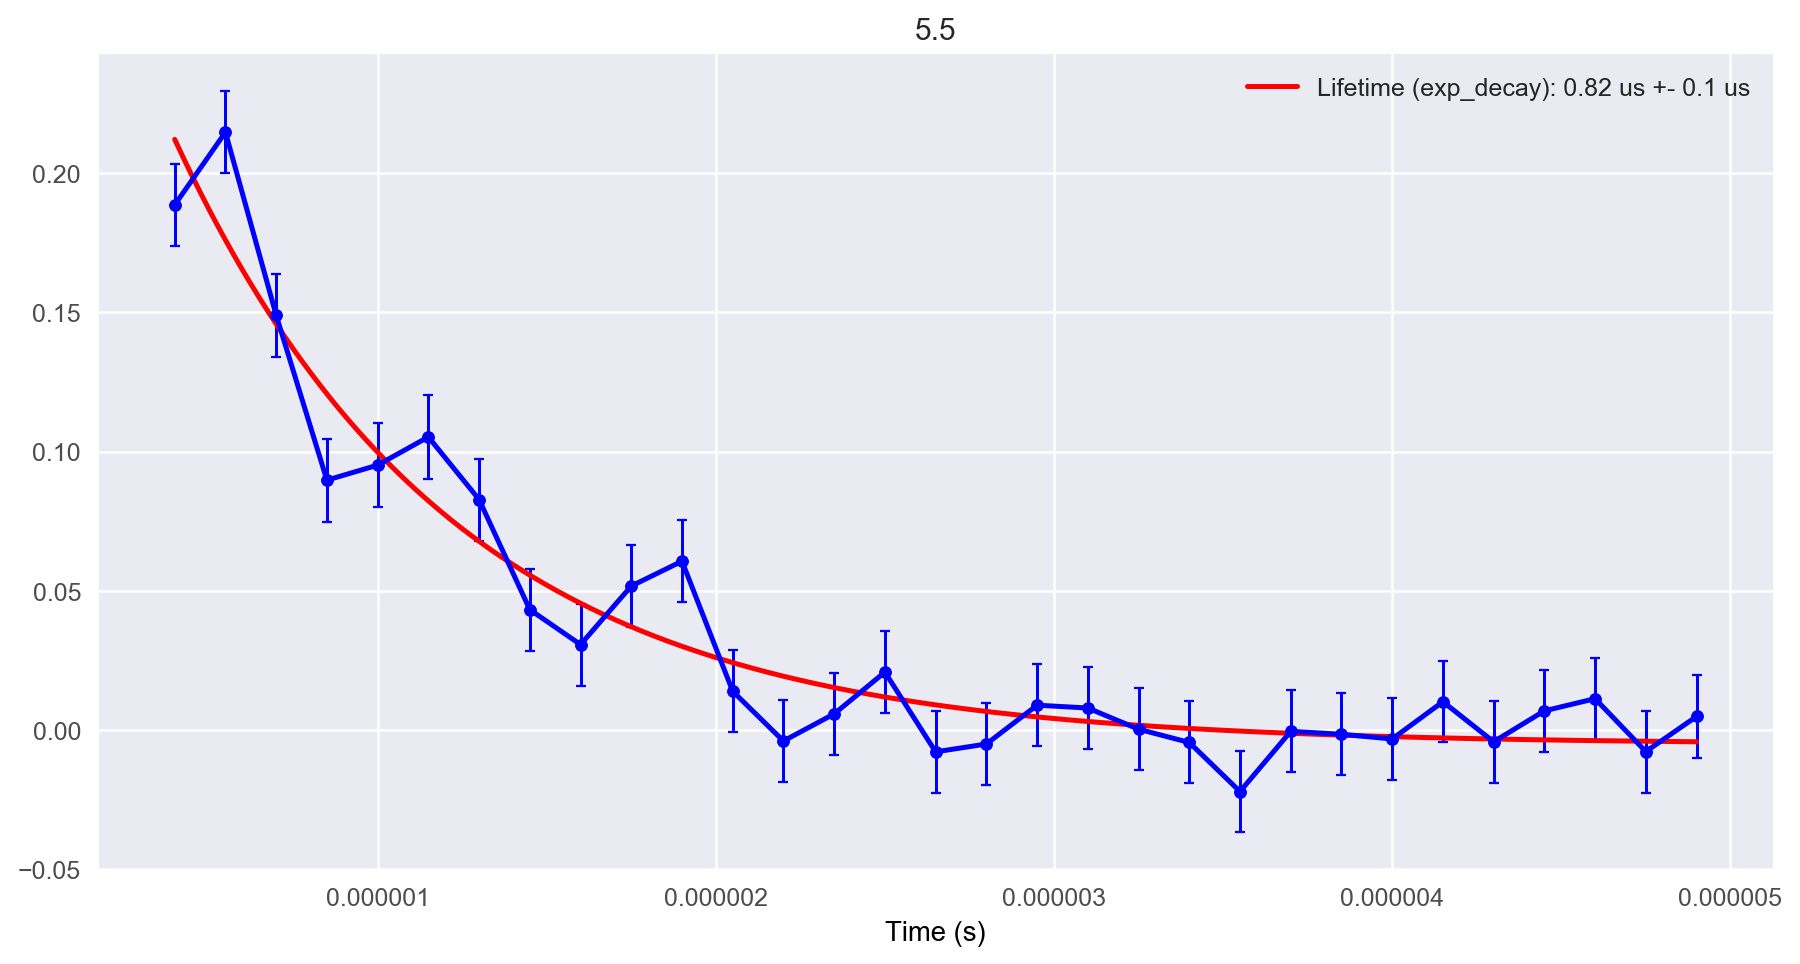

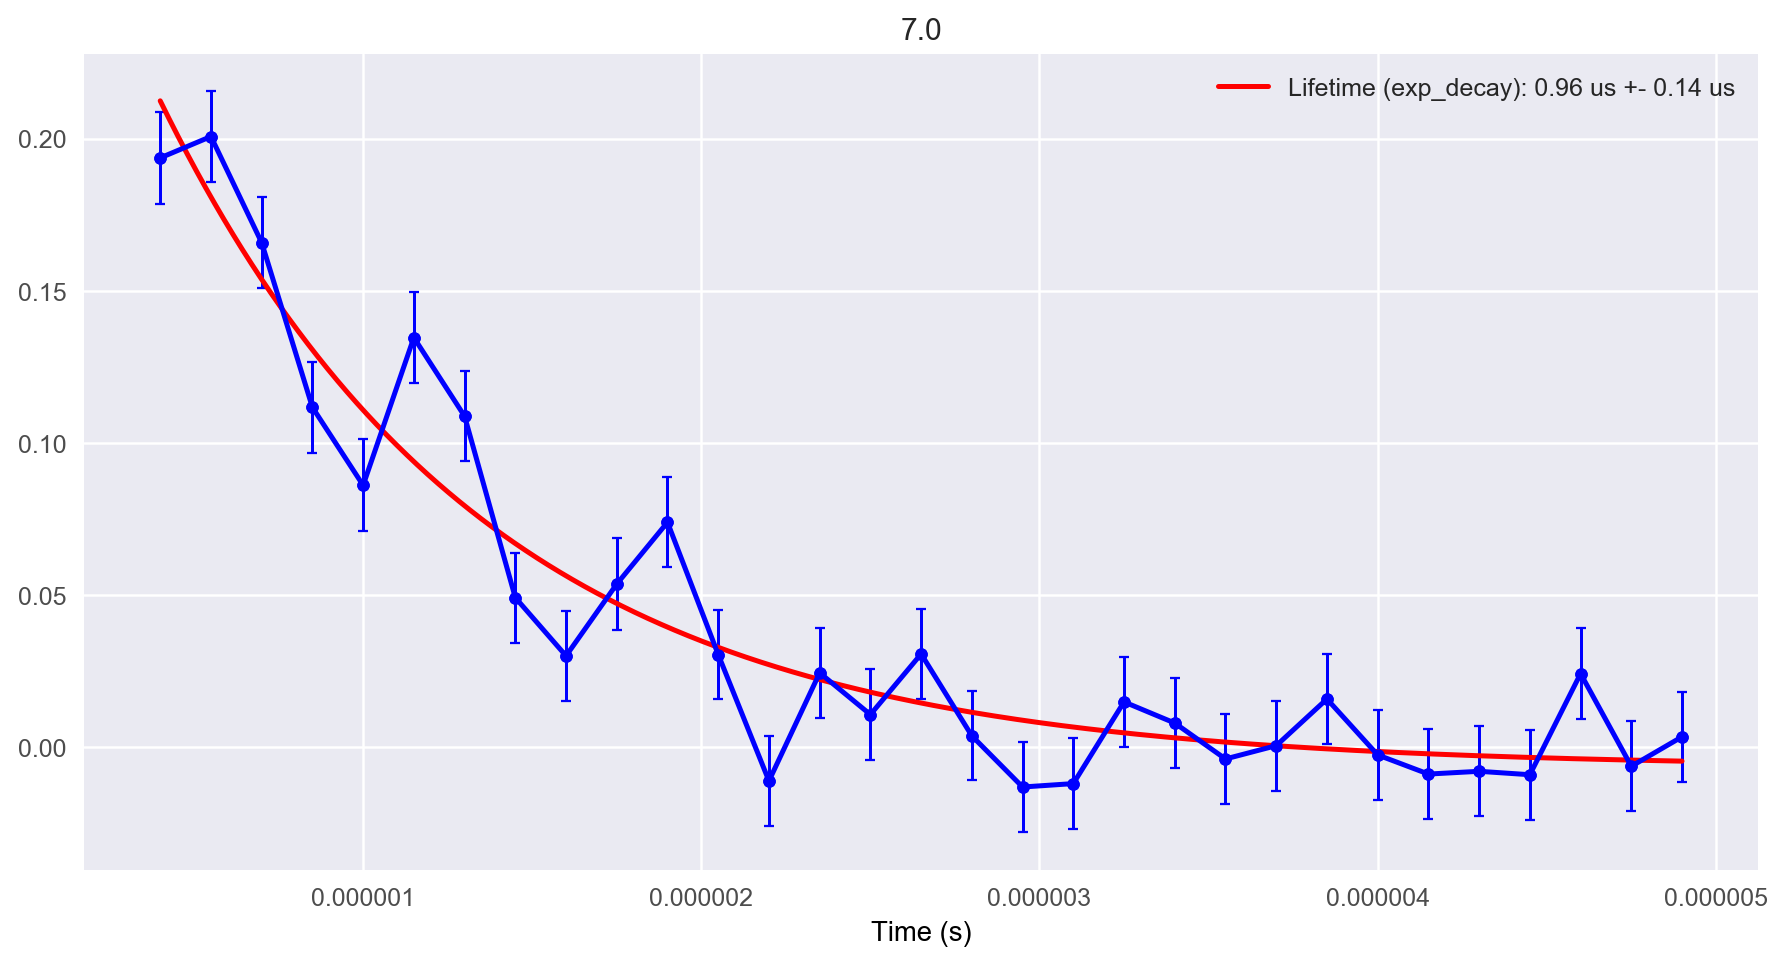

In [64]:
from lmfit import Parameter
hecho_meas0 = np.zeros(len(hechos))
hecho_meas0_err = np.zeros(len(hechos))
hecho_meas1 = np.zeros(len(hechos))
temp = np.zeros(len(hechos))

for i in range(len(hechos[:])):
    path = hechos[i]
    data_raw = np.loadtxt(path).T
    
    tempstr = re.search(r'temp_.*K', path)
    temp[i] = float(tempstr.group()[5:-1])
    
    var_list = data_raw[0]

    mode = 'exp_decay'
    plot_option = 3 #1 = Signal1, 2 = Signal2, 3 = delta of signals
    err = None

    #Choose what to plot
    if plot_option == 3:
        data = data_raw[1] - data_raw[2]
        shift = (data_raw.shape[0]-1)//2
        err1 = abs(data_raw[1+shift])
        err2 = abs(data_raw[2+shift])
        err = err1+err2
    else:
        data = data_raw[plot_option]
        shift = (data_raw.shape[0]-1)//2
        err = data_raw[plot_option+shift]
        

    plt.title(f"{temp[i]}")

    plt.xlabel('Frequency (Hz)')

    #Determine fi
    if mode == 'exp_decay':
        fit = afm_scanner_logic._fitlogic.make_decayexponential_fit(var_list[:],data[:],estimator=afm_scanner_logic._fitlogic.estimate_decayexponential)
        lm,_ = fitlogic.make_decayexponential_model()
        leg = f"Lifetime ({mode}): {round(fit.params['lifetime']*1e6,2)} us +- {round(fit.params['lifetime'].stderr*1e6,2)} us"
        plt.xlabel('Time (s)')
        
    elif mode=='test_model_decay_2gaussian':
        lm,params_decay = fitlogic.make_decayexponential_model()
        gm0,params_g0 = fitlogic.make_gaussian_model(prefix='g0')
        gm1,params_g1 = fitlogic.make_gaussian_model(prefix='g1')
        com_model = lm+gm0+gm1
        com_params = com_model.make_params()
        lm = com_model
        
        errors, params_decay = afm_scanner_logic._fitlogic.estimate_decayexponential(var_list[:],data[:],params_decay)
        com_params = fitlogic._substitute_params(initial_params=com_params, update_params=params_decay)
        
        com_params['g0center'] = Parameter(name='g0center', value=1.2e-6, min=var_list[:].min(), max=var_list[:].max())
        com_params['g0amplitude'] = Parameter(name='g0amplitude', value=20e-3, min=0, max=1)
        com_params['g0offset'] = Parameter(name='g0offset', value=0, min=-1, max=40e-3)
        com_params['g0sigma'] = Parameter(name='g0sigma', value=0.1e-6, min=1e-9, max=1)
        com_params['g1center'] = Parameter(name='g1center', value=1.8e-6, min=var_list[:].min(), max=var_list[:].max())
        com_params['g1amplitude'] = Parameter(name='g1amplitude', value=20e-3, min=0, max=1)
        com_params['g1offset'] = Parameter(name='g1offset', value=0, min=-1, max=1)
        com_params['g1sigma'] = Parameter(name='g1sigma', value=0.1e-6, min=1e-9, max=1)

        fit = com_model.fit(data[:], com_params, x=var_list[:])
        leg = f"Lifetime ({mode}): {round(fit.params['lifetime']*1e6,2)} us +- {round(fit.params['lifetime'].stderr*1e6,2)} us"
        plt.xlabel('Time (s)')


    #Plot Data an
    plt.plot(var_list,data,'bo')
    if not err is None:
        plt.errorbar(x=var_list, y=data,
                     yerr=err, fmt='-o', color='blue',
                     capsize=2, capthick=0.9,
                     elinewidth=1.2)

    x = np.linspace(var_list[0],var_list[-1],10000, endpoint=True)
    plt.plot(x, lm.eval(fit.params, x=x),'r-',label=leg)

    plt.legend()

#     plt.rcParams['figure.figsize'] = (9, 6)
#     fontsize = 12
#     # with open(filepath+f'_jupyter_plot_{plot_option}_{mode}.png', 'wb') as f:
#     #     plt.savefig(f,format='png',dpi=600)
    plt.show()
    hecho_meas0[i] = fit.params['lifetime']*1e6
    hecho_meas0_err[i] = fit.params['lifetime'].stderr*1e6



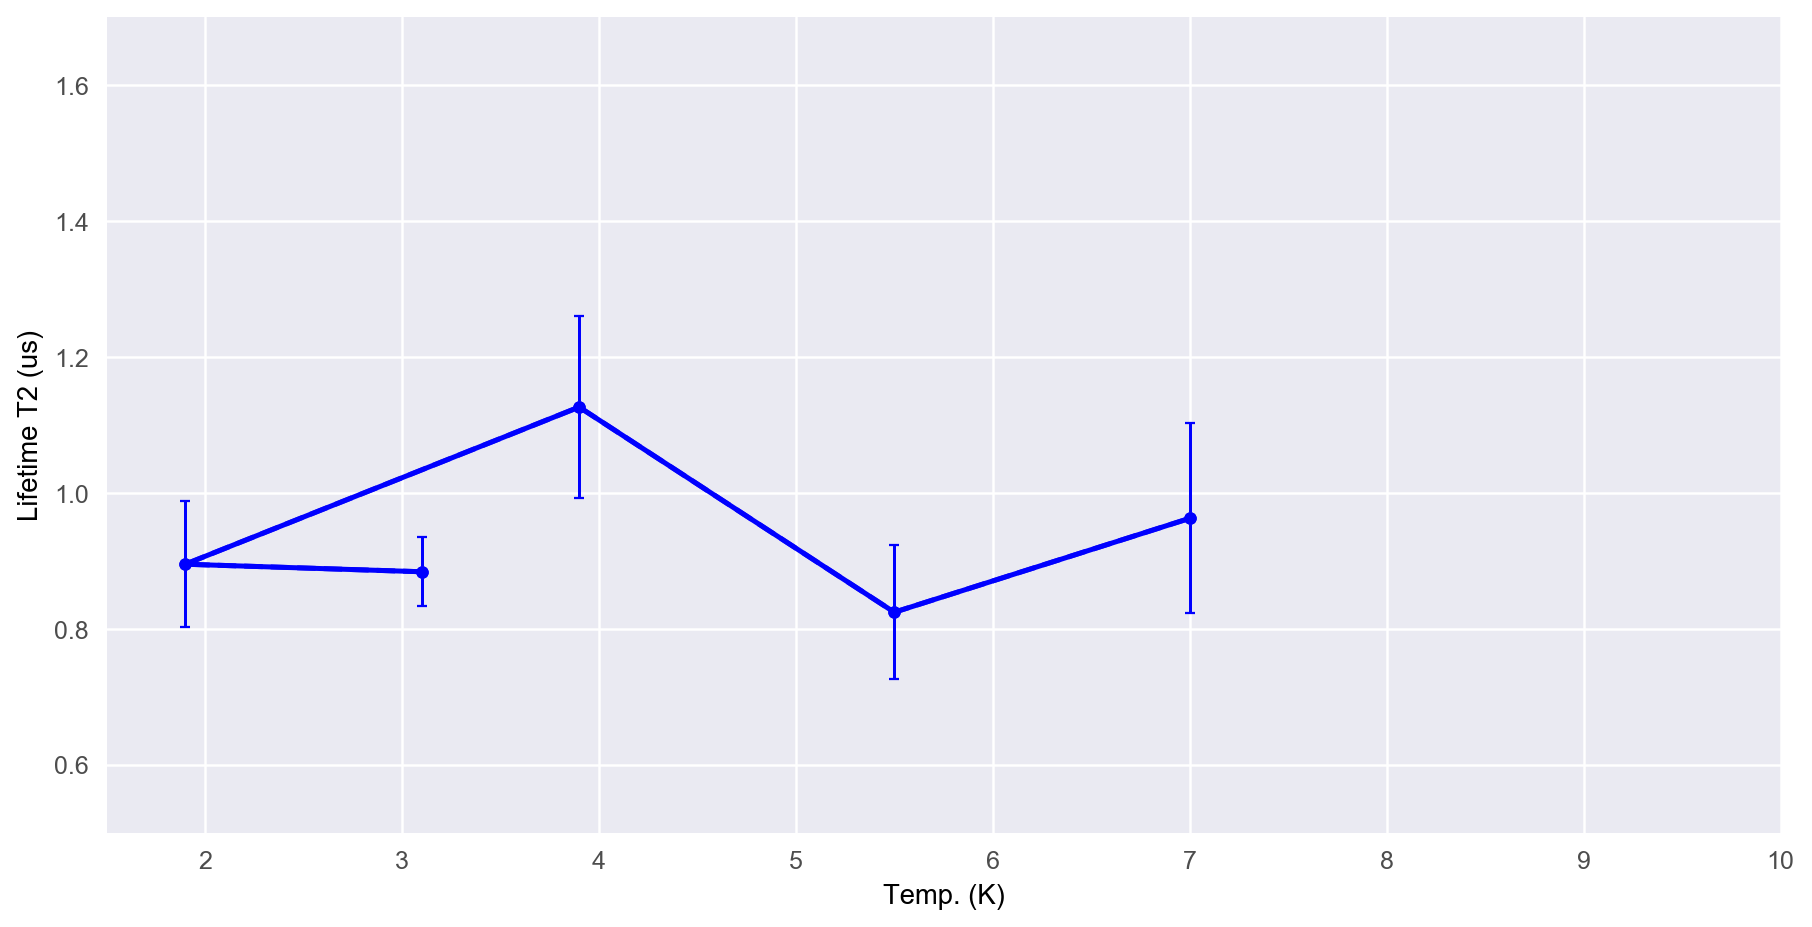

Traceback (most recent call last):
  File "C:\Users\yy3\Documents\Software\qudi\logic\jupyterkernel\qzmqkernel.py", line 679, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-2d30bc750f21>", line 13, in <module>
    yerr=podmr_meas2_err, fmt='-o', color='blue',
NameError: name 'podmr_meas2_err' is not defined


In [65]:
plt.plot(temp, hecho_meas0,'o--')

plt.errorbar(x=temp, y=hecho_meas0,
                     yerr=hecho_meas0_err, fmt='-o', color='blue',
                     capsize=2, capthick=0.9,
                     elinewidth=1.2)

plt.xlabel('Temp. (K)')
plt.ylabel('Lifetime T2 (us)')
plt.ylim(0.5,1.7)
plt.xlim(1.5,10)
plt.show()